[Tutorial](https://lightning.ai/docs/pytorch/stable/starter/introduction.html)

In [9]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
import torch.utils.data as data
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import lightning as L
from lightning.pytorch import Trainer, seed_everything
import os
import pandas as pd
from torchvision.io import read_image, decode_image
from torchvision.transforms.v2 import Normalize
from torchvision.transforms import Resize
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
SEED = 5
seed_everything(SEED, workers=True)

Seed set to 5


5

In [10]:
def dir_to_df(PATH:os.path)-> pd.DataFrame:
    data_dict = {"image_path":[],"label":[]}
    for label in os.listdir(PATH):
        if os.path.isdir(os.path.join(PATH,label)):
            image_path = [os.path.join(os.path.join(PATH,label),i) for i in os.listdir(os.path.join(PATH,label))]
            label_list = [label]*len(image_path)
            data_dict["image_path"].extend(image_path)
            data_dict["label"].extend(label_list)

    data_df = pd.DataFrame.from_dict(data_dict)
    return data_df

In [12]:
## Make a dataframe with the label
## Train
DATASET_PATH = os.path.join("..","dataset","inaturalist_12K")
TRAIN_PATH = os.path.join(DATASET_PATH,'train')
TEST_PATH = os.path.join(DATASET_PATH,'val')

train_df = dir_to_df(TRAIN_PATH)
test_df = dir_to_df(TEST_PATH)
class_mapping_dict = {j:i+1 for i,j in enumerate(test_df["label"].unique())}
train_df["label_id"] = train_df["label"].map(class_mapping_dict)
test_df["label_id"] = test_df["label"].map(class_mapping_dict)
## Randomize the dataframe
train_df = train_df.sample(frac=1.0)
test_df = test_df.sample(frac=1.0)

In [13]:
train_df.head()

,image_path,label,label_id
7054,..\dataset\inaturalist_12K\train\Mollusca\0d0b...,Mollusca,8
442,..\dataset\inaturalist_12K\train\Amphibia\7517...,Amphibia,1
3954,..\dataset\inaturalist_12K\train\Aves\f51df107...,Aves,4
2288,..\dataset\inaturalist_12K\train\Arachnida\4c1...,Arachnida,3
3196,..\dataset\inaturalist_12K\train\Aves\39ede910...,Aves,4


In [18]:
from torchvision.transforms import v2
from torchvision.transforms.v2 import Normalize
from torchvision.transforms import Resize
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import decode_image

image_normalization = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


class CustomImageDataset(Dataset):
    def __init__(
        self,
        dataset_df: pd.DataFrame,
        image_normalization: Normalize,
        size: tuple = (256, 256),
        augmentation: bool = False,
    ):
        self.dataset_df = dataset_df
        self.image_normalization = image_normalization
        self.size = size
        self.augmentation = augmentation
        if self.augmentation:
            ## Do augmentation
            self.transform = v2.Compose(
                [
                    Resize(size=size),
                    v2.RandomHorizontalFlip(p=0.5),
                    v2.RandomRotation(
                        degrees=10,
                    ),
                    v2.ColorJitter(),
                ]
            )
        else:
            ## No augmentation
            self.transform = v2.Compose([Resize(size=size)])

    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx: int):
        img_path = self.dataset_df.iloc[idx]["image_path"]  # .values[0]
        image = decode_image(img_path, mode="RGB")
        image = self.transform(image)
        image = self.image_normalization(image / image.max())

        label = self.dataset_df.iloc[idx]["label_id"]  # .values[0]
        return image, label


In [34]:
train_dataset = CustomImageDataset(dataset_df = train_df, image_normalization = image_normalization, augmentation = False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.64].


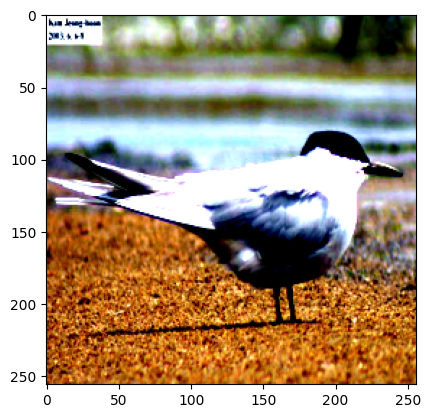

In [40]:
X,y = train_dataset.__getitem__(4)
plt.imshow(X.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


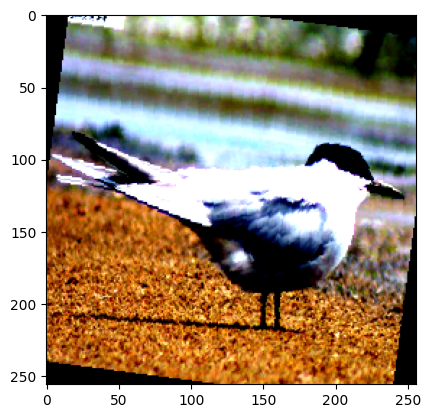

In [25]:
from torch.utils.data import DataLoader
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

## Data loader
train_dataset = CustomImageDataset(dataset_df = train_df, image_normalization = image_normalization)
test_dataset = CustomImageDataset(dataset_df = test_df, image_normalization = image_normalization)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True, pin_memory=False)#, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, drop_last=True, pin_memory=False)#, num_workers=1)


In [26]:
imgs, labels = next(iter(train_loader))


In [28]:
imgs.shape

torch.Size([8, 3, 256, 256])

## Build the CNN model with flexibility

In [ ]:
from config import config
from CNNNetwork import CNNNetwork
from LightningModule import LightningModule
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl

In [ ]:
# Create dummy data
num_samples = 100
input_size = (3, 32, 32)  # Example input size
X = torch.randn(num_samples, *input_size)
y = torch.randint(0, 101010, (num_samples,))  # Dummy labels
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32)
#val_loader = DataLoader(dataset, batch_size=32)
conf = config()
# Create and train the model
model = CNNNetwork(num_conv_layers=2, num_classes = 10)  # Reduced for testing
lit_model = LightningModule(model)
trainer = pl.Trainer(max_epochs=2, accelerator="gpu", devices=1) #Added accelerator gpu, can be cpu also, devices set to 1

trainer.fit(lit_model, train_loader)#, val_loader)

In [3]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)

In [8]:
output.sum(axis=1)

tensor([1., 1.])